In [1]:
import pandas as pd
import numpy as np
import pymysql
import getpass
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
conn = pymysql.connect(host="localhost",
                       port=3306,
                       user="ironhack",
                       passwd=getpass.getpass(),
                       db="olist")

········


# Timeseries / Trends / Growth

II. Orders

In [3]:
orders_query = """
SELECT
    DATE_SUB(DATE(order_purchase_timestamp), INTERVAL DAYOFWEEK(order_purchase_timestamp)-1 DAY) AS week_id,
    COUNT(1)                                                                                     AS orders
FROM olist.orders
WHERE DATE(order_purchase_timestamp) >= '2017-01-01'
    AND DATE(order_purchase_timestamp) < '2018-08-26'
GROUP BY 1
ORDER BY 1;
"""

weekly_orders = pd.read_sql(orders_query, conn)

In [4]:
weekly_orders.dtypes

week_id    object
orders      int64
dtype: object

In [5]:
weekly_orders["week_id"] = pd.to_datetime(weekly_orders["week_id"])

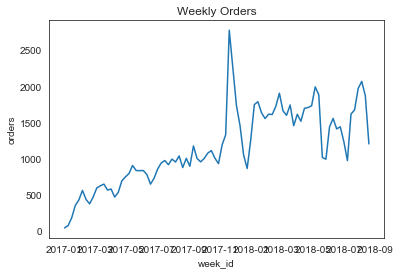

In [6]:
sns.lineplot(data=weekly_orders,
             x="week_id",
             y="orders").set_title("Weekly Orders");

Take a look at monthly data

In [7]:
monthly_orders_query = """
SELECT
    DATE_FORMAT(order_purchase_timestamp, '%Y-%m-01') AS month_id,
    COUNT(1)                                                                                     AS orders
FROM olist.orders
WHERE DATE(order_purchase_timestamp) >= '2017-01-01'
    AND DATE(order_purchase_timestamp) < '2018-09-01'
GROUP BY 1
ORDER BY 1;
"""

monthly_orders = pd.read_sql(monthly_orders_query, conn)

In [8]:
monthly_orders.head()

,month_id,orders
0,2017-01-01,800
1,2017-02-01,1780
2,2017-03-01,2682
3,2017-04-01,2404
4,2017-05-01,3700


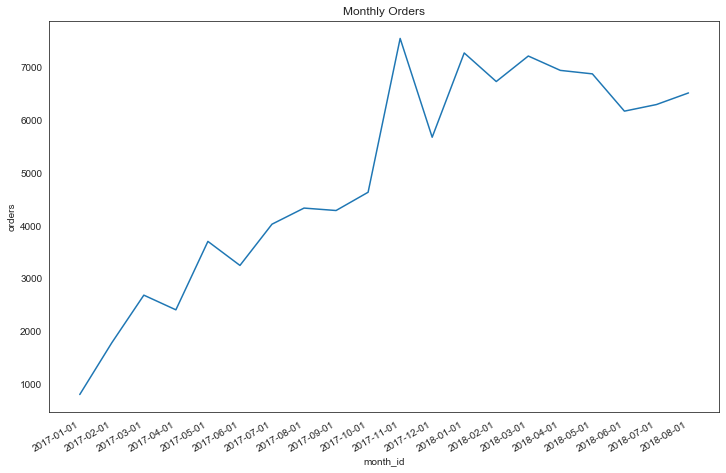

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=monthly_orders,
             x="month_id",
             y="orders").set_title("Monthly Orders");
# automatically rotate date ticks to not ovetrlap
fig.autofmt_xdate();

To account for seasonality, we may want to compare same months across years

In [10]:
orders_year_month_query = """
SELECT
    DATE_FORMAT(order_purchase_timestamp, '%Y-%m-01')   AS month_id,
    MONTH(order_purchase_timestamp)                     AS month_in_year,
    YEAR(order_purchase_timestamp)                      AS year,
    COUNT(1)                                            AS orders
FROM olist.orders
WHERE DATE(order_purchase_timestamp) >= '2017-01-01'
    AND DATE(order_purchase_timestamp) < '2018-09-01'
GROUP BY 1,2,3
ORDER BY 1;
"""

orders_year_month = pd.read_sql(orders_year_month_query, conn)

In [11]:
orders_year_month

,month_id,month_in_year,year,orders
0,2017-01-01,1,2017,800
1,2017-02-01,2,2017,1780
2,2017-03-01,3,2017,2682
3,2017-04-01,4,2017,2404
4,2017-05-01,5,2017,3700
5,2017-06-01,6,2017,3245
6,2017-07-01,7,2017,4026
7,2017-08-01,8,2017,4331
8,2017-09-01,9,2017,4285
9,2017-10-01,10,2017,4631


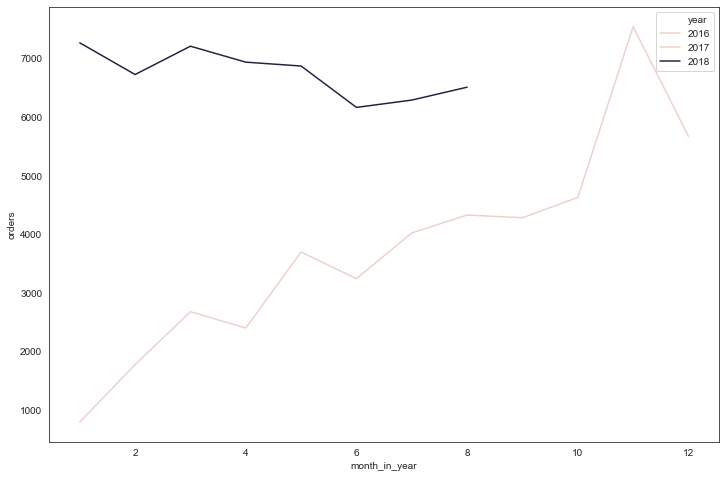

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=orders_year_month,
             x="month_in_year",
             y="orders",
             hue="year",
             ax=ax);

In [13]:
monthly_perf_query = """
SELECT
    DATE_FORMAT(o.order_purchase_timestamp, '%Y-%m-01') AS month_id,
    MONTH(o.order_purchase_timestamp)                   AS month_in_year,
    YEAR(o.order_purchase_timestamp)                    AS year,
    COUNT(1)                                            AS items_sold,
    COUNT(DISTINCT o.order_id)                          AS orders,
    SUM(oi.price)                                       AS revenue,
    COUNT(DISTINCT seller_id)                           AS sellers
FROM olist.orders o
    JOIN olist.order_items oi
    ON o.order_id = oi.order_id
WHERE TRUE
    AND DATE(order_purchase_timestamp) >= '2017-01-01'
    AND DATE(order_purchase_timestamp) < '2018-09-01'
GROUP BY 1,2,3
ORDER BY 1;
"""

monthly_perf = pd.read_sql(monthly_perf_query, conn)

In [14]:
monthly_perf

,month_id,month_in_year,year,items_sold,orders,revenue,sellers
0,2017-01-01,1,2017,955,789,1.203129e+05,227
1,2017-02-01,2,2017,1951,1733,2.473030e+05,427
2,2017-03-01,3,2017,3000,2641,3.743443e+05,499
3,2017-04-01,4,2017,2684,2391,3.599272e+05,506
4,2017-05-01,5,2017,4136,3660,5.060711e+05,583
5,2017-06-01,6,2017,3583,3217,4.330386e+05,539
6,2017-07-01,7,2017,4519,3969,4.980315e+05,606
7,2017-08-01,8,2017,4910,4293,5.739717e+05,708
8,2017-09-01,9,2017,4831,4243,6.244017e+05,731
9,2017-10-01,10,2017,5322,4568,6.642194e+05,776


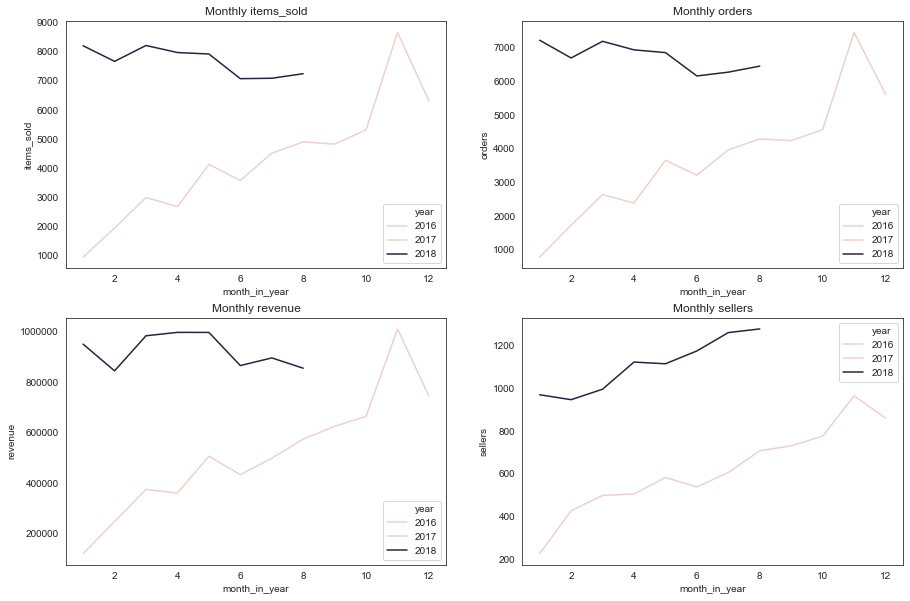

In [15]:
fig, axes = plt.subplots(nrows=2,
                         ncols=2,
                         figsize=(15,10))

metrics = ["items_sold", "orders", "revenue", "sellers"]

i = 0
for ax in axes.flatten():
    sns.lineplot(data=monthly_perf,
                 x="month_in_year",
                 y=metrics[i],
                 hue="year",
                 ax=ax).set_title(f"Monthly {metrics[i]}")
    i+=1

Generate
- items per order
- orders per seller
- revenue per seller

In [16]:
monthly_perf.head()

,month_id,month_in_year,year,items_sold,orders,revenue,sellers
0,2017-01-01,1,2017,955,789,120312.869803,227
1,2017-02-01,2,2017,1951,1733,247303.019816,427
2,2017-03-01,3,2017,3000,2641,374344.299496,499
3,2017-04-01,4,2017,2684,2391,359927.229713,506
4,2017-05-01,5,2017,4136,3660,506071.139302,583


In [17]:
(monthly_perf["items_sold"] / monthly_perf["orders"]).head()

0    1.210393
1    1.125793
2    1.135933
3    1.122543
4    1.130055
dtype: float64

In [18]:
monthly_perf = (monthly_perf
                .assign(items_per_order=monthly_perf["items_sold"] / monthly_perf["orders"])
                .assign(orders_per_seller=monthly_perf["orders"] / monthly_perf["sellers"])
                .assign(revenue_per_seller=monthly_perf["revenue"] / monthly_perf["sellers"]))

In [19]:
monthly_perf

,month_id,month_in_year,year,items_sold,orders,revenue,sellers,items_per_order,orders_per_seller,revenue_per_seller
0,2017-01-01,1,2017,955,789,1.203129e+05,227,1.210393,3.475771,530.012642
1,2017-02-01,2,2017,1951,1733,2.473030e+05,427,1.125793,4.058548,579.163981
2,2017-03-01,3,2017,3000,2641,3.743443e+05,499,1.135933,5.292585,750.188977
3,2017-04-01,4,2017,2684,2391,3.599272e+05,506,1.122543,4.725296,711.318636
4,2017-05-01,5,2017,4136,3660,5.060711e+05,583,1.130055,6.277873,868.046551
5,2017-06-01,6,2017,3583,3217,4.330386e+05,539,1.113771,5.968460,803.411132
6,2017-07-01,7,2017,4519,3969,4.980315e+05,606,1.138574,6.549505,821.834126
7,2017-08-01,8,2017,4910,4293,5.739717e+05,708,1.143722,6.063559,810.694464
8,2017-09-01,9,2017,4831,4243,6.244017e+05,731,1.138581,5.804378,854.174678
9,2017-10-01,10,2017,5322,4568,6.642194e+05,776,1.165061,5.886598,855.952874


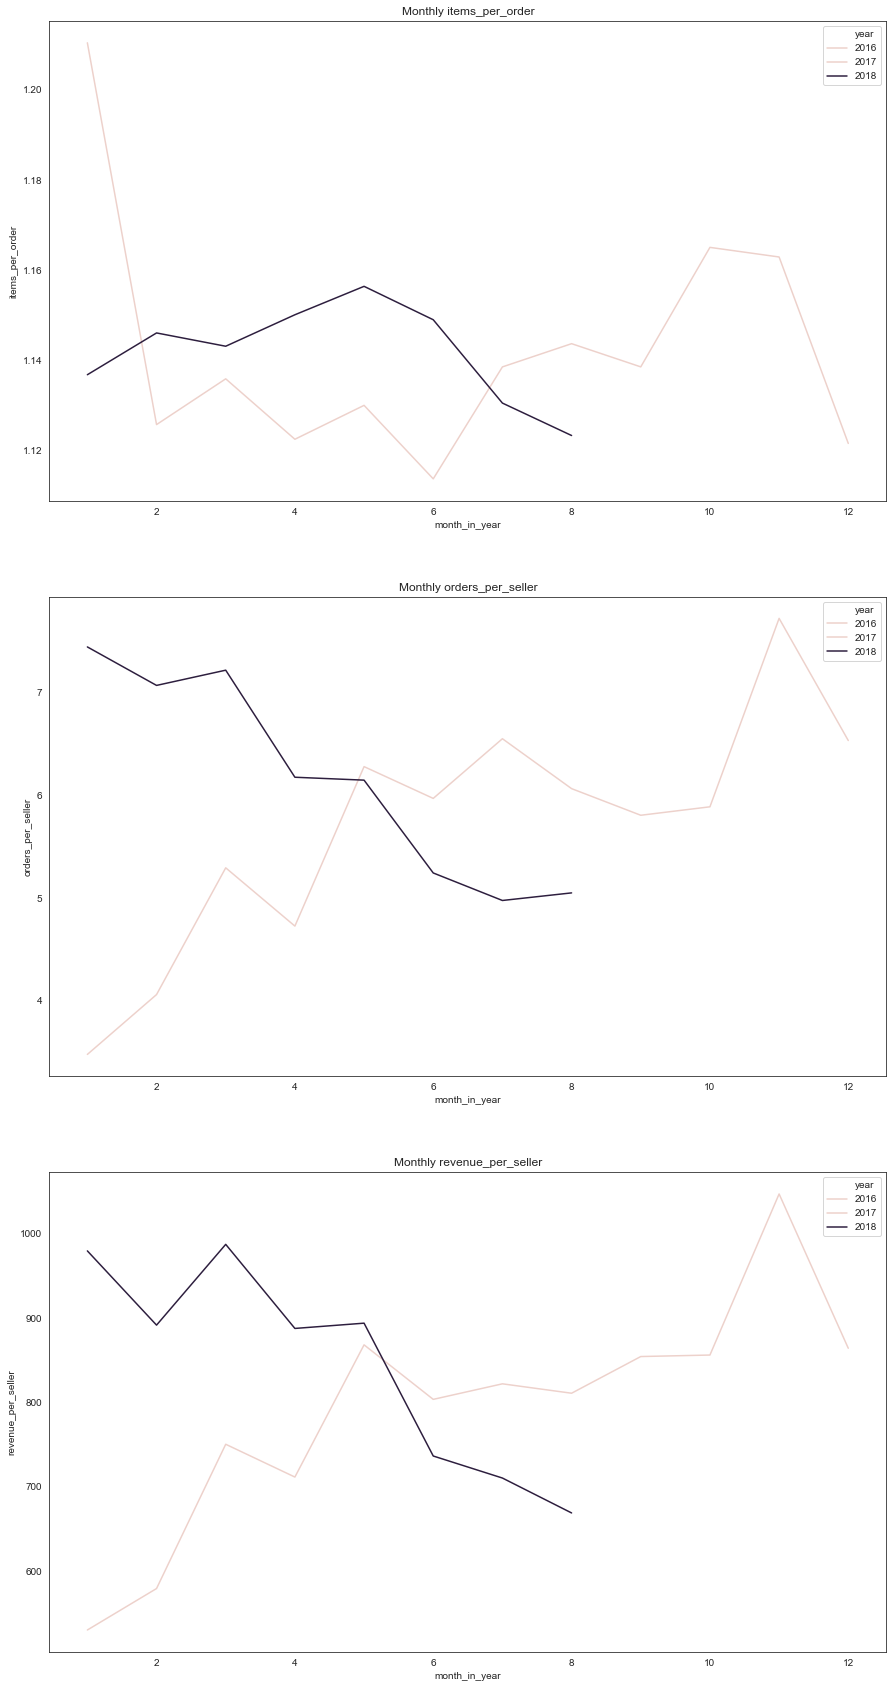

In [20]:
fig, axes = plt.subplots(nrows=3,
                         ncols=1,
                         figsize=(15,30))

ratios = ["items_per_order", "orders_per_seller", "revenue_per_seller"]

i = 0
for ax in axes.flatten():
    sns.lineplot(data=monthly_perf,
                 x="month_in_year",
                 y=ratios[i],
                 hue="year",
                 ax=ax).set_title(f"Monthly {ratios[i]}")
    i+=1

## Drilling down into revenue

### Split revenue by customer states

In [21]:
monthly_rev_by_cstates_query = """
SELECT
    DATE_FORMAT(o.order_purchase_timestamp, '%Y-%m-01') AS month_id,
    MONTH(o.order_purchase_timestamp)                   AS month_in_year,
    YEAR(o.order_purchase_timestamp)                    AS year,
    c.customer_state,
    SUM(price)                  AS revenue
FROM olist.order_items oi
    JOIN olist.orders o
    ON oi.order_id = o.order_id
    JOIN olist.customers c
    ON o.customer_id = c.customer_id
WHERE TRUE
    AND DATE(order_purchase_timestamp) >= '2017-01-01'
    AND DATE(order_purchase_timestamp) < '2018-09-01'
GROUP BY
    month_id,
    month_in_year,
    year,
    customer_state
ORDER BY
    1,2;
"""

monthly_rev_by_cstates = pd.read_sql(monthly_rev_by_cstates_query, conn)

In [22]:
monthly_rev_by_cstates

,month_id,month_in_year,year,customer_state,revenue
0,2017-01-01,1,2017,AC,589.599991
1,2017-01-01,1,2017,AL,393.970016
2,2017-01-01,1,2017,BA,3956.020004
3,2017-01-01,1,2017,CE,1049.490005
4,2017-01-01,1,2017,DF,1826.630011
...,...,...,...,...,...
528,2018-08-01,8,2018,RS,43141.599936
529,2018-08-01,8,2018,SC,32355.830109
530,2018-08-01,8,2018,SE,4558.040003
531,2018-08-01,8,2018,SP,396613.490093


In [23]:
monthly_rev_by_cstates.dtypes

month_id           object
month_in_year       int64
year                int64
customer_state     object
revenue           float64
dtype: object

In [24]:
monthly_rev_by_cstates["month_id"] = pd.to_datetime(monthly_rev_by_cstates["month_id"])

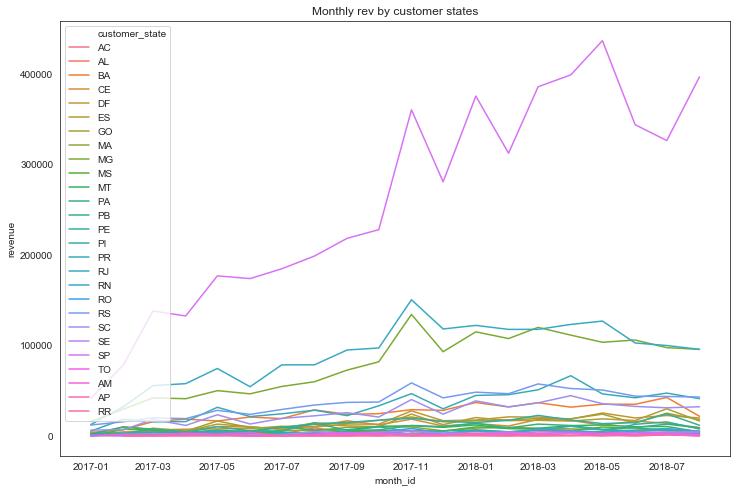

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=monthly_rev_by_cstates,
             x="month_id",
             y="revenue",
             hue="customer_state",
             ax=ax).set_title("Monthly rev by customer states");

Too many states to show. Keep the top states and group the rest into one state 'Other'.

Approach:
Keep top 6 states in 2018-08, group the rest

In [26]:
# first, we need to get the top 6 states in 2018-08
(monthly_rev_by_cstates
 .loc[monthly_rev_by_cstates["month_id"].eq("2018-08-01"),]
 .nlargest(6, "revenue"))

,month_id,month_in_year,year,customer_state,revenue
531,2018-08-01,8,2018,SP,396613.490093
525,2018-08-01,8,2018,RJ,95762.979989
517,2018-08-01,8,2018,MG,95736.419767
528,2018-08-01,8,2018,RS,43141.599936
524,2018-08-01,8,2018,PR,41305.209914
529,2018-08-01,8,2018,SC,32355.830109


In [27]:
(monthly_rev_by_cstates
 .loc[monthly_rev_by_cstates["month_id"].eq("2018-08-01"),]
 .nlargest(6, "revenue")["customer_state"]).values

array(['SP', 'RJ', 'MG', 'RS', 'PR', 'SC'], dtype=object)

In [28]:
top_states = list(monthly_rev_by_cstates
                  .loc[monthly_rev_by_cstates["month_id"].eq("2018-08-01"),]
                  .nlargest(6, "revenue")["customer_state"].values)

In [29]:
top_states

['SP', 'RJ', 'MG', 'RS', 'PR', 'SC']

In [30]:
# define a function that groups states into 'other' if they are not in top_states
def group_states(state, top_state_list):
    if state in top_state_list:
        return state
    else:
        return "Other"

In [31]:
(monthly_rev_by_cstates
 .loc[monthly_rev_by_cstates["month_id"].eq("2018-08-01"),]
 .nlargest(10, "revenue"))

,month_id,month_in_year,year,customer_state,revenue
531,2018-08-01,8,2018,SP,396613.490093
525,2018-08-01,8,2018,RJ,95762.979989
517,2018-08-01,8,2018,MG,95736.419767
528,2018-08-01,8,2018,RS,43141.599936
524,2018-08-01,8,2018,PR,41305.209914
529,2018-08-01,8,2018,SC,32355.830109
511,2018-08-01,8,2018,BA,21846.839976
513,2018-08-01,8,2018,DF,19941.629945
515,2018-08-01,8,2018,GO,18063.890013
514,2018-08-01,8,2018,ES,16610.039952


In [32]:
group_states("SP", top_states)

'SP'

In [33]:
group_states("ES", top_states)

'Other'

In [34]:
# define a function that groups states into 'other' if they are not in top_states
# def group_states(state, top_state_list):
#     if state in top_state_list:
#         return state
#     else:
#         return "Other"

# rewrite as lambda function
(lambda x: x if x in top_states else "Other")("SP")

'SP'

In [35]:
monthly_rev_by_cstates["customer_state"].apply(lambda x: x+"X")

0      ACX
1      ALX
2      BAX
3      CEX
4      DFX
      ... 
528    RSX
529    SCX
530    SEX
531    SPX
532    TOX
Name: customer_state, Length: 533, dtype: object

In [36]:
monthly_rev_by_cstates = monthly_rev_by_cstates.assign(grouped_customer_state=monthly_rev_by_cstates["customer_state"]
                                                       .apply(lambda state: state if state in top_states else "Other"))

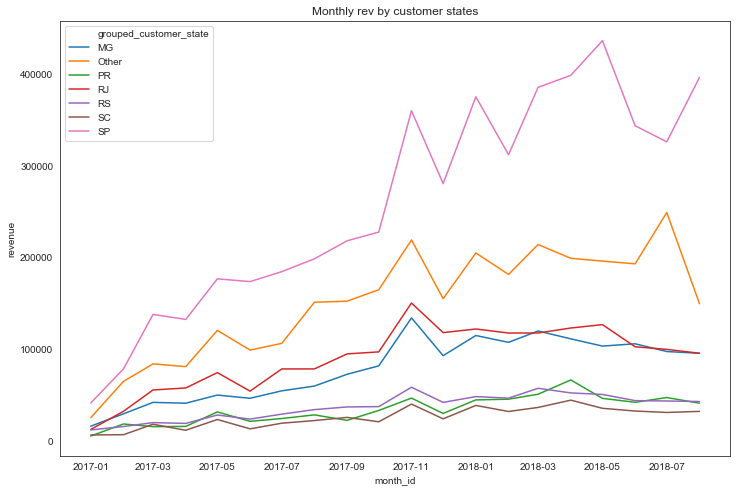

In [37]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=(monthly_rev_by_cstates
                   .groupby(["month_id","grouped_customer_state"])
                   .agg({"revenue": "sum"})
                   .reset_index()),
             x="month_id",
             y="revenue",
             hue="grouped_customer_state",
             ax=ax).set_title("Monthly rev by customer states");

In [39]:
monthly_rev_by_cstates.tail(20)

,month_id,month_in_year,year,customer_state,revenue,grouped_customer_state
513,2018-08-01,8,2018,DF,19941.629945,Other
514,2018-08-01,8,2018,ES,16610.039952,Other
515,2018-08-01,8,2018,GO,18063.890013,Other
516,2018-08-01,8,2018,MA,4246.200000,Other
517,2018-08-01,8,2018,MG,95736.419767,MG
518,2018-08-01,8,2018,MS,5551.429983,Other
519,2018-08-01,8,2018,MT,4648.230000,Other
520,2018-08-01,8,2018,PA,8928.779978,Other
521,2018-08-01,8,2018,PB,7751.629988,Other
522,2018-08-01,8,2018,PE,11927.030014,Other


### Manually add mom relative growth for each state as a column

In [44]:
pd.DateOffset(month=1)

<DateOffset: month=1>

In [48]:
monthly_rev_by_cstates["month_id"]

0     2017-01-01
1     2017-01-01
2     2017-01-01
3     2017-01-01
4     2017-01-01
         ...    
528   2018-08-01
529   2018-08-01
530   2018-08-01
531   2018-08-01
532   2018-08-01
Name: month_id, Length: 533, dtype: datetime64[ns]

In [53]:
pd.to_datetime("2018-08-01") + pd.DateOffset(months=1)

Timestamp('2018-09-01 00:00:00')

In [56]:
monthly_rev_by_cstates = monthly_rev_by_cstates.assign(shifted_month=monthly_rev_by_cstates["month_id"] + pd.DateOffset(months=1))

In [58]:
monthly_rev_by_cstates.head()

,month_id,month_in_year,year,customer_state,revenue,grouped_customer_state,shifted_month
0,2017-01-01,1,2017,AC,589.599991,Other,2017-02-01
1,2017-01-01,1,2017,AL,393.970016,Other,2017-02-01
2,2017-01-01,1,2017,BA,3956.020004,Other,2017-02-01
3,2017-01-01,1,2017,CE,1049.490005,Other,2017-02-01
4,2017-01-01,1,2017,DF,1826.630011,Other,2017-02-01


In [75]:
monthly_rev_growth = (monthly_rev_by_cstates
                      .merge(right=monthly_rev_by_cstates,
                             how="left",
                             left_on=["month_id", "customer_state"],
                             right_on=["shifted_month", "customer_state"])
                     )[["month_id_x",
                        "month_in_year_x",
                        "year_x",
                        "customer_state",
                        "grouped_customer_state_x",
                        "revenue_x",
                        "revenue_y"]]

In [76]:
monthly_rev_growth.columns = [col.replace("_x","") for col in monthly_rev_growth.columns]

In [77]:
monthly_rev_growth.assign(abs_diff=monthly_rev_growth["revenue"] - monthly_rev_growth["revenue_y"]).tail(30)

,month_id,month_in_year,year,customer_state,grouped_customer_state,revenue,revenue_y,abs_diff
503,2018-07-01,7,2018,SC,SC,31203.580072,32740.719971,-1537.139898
504,2018-07-01,7,2018,SE,Other,4442.340004,3849.089979,593.250025
505,2018-07-01,7,2018,SP,SP,326319.189844,343828.569885,-17509.380042
506,2018-07-01,7,2018,TO,Other,2613.670006,4049.420000,-1435.749994
507,2018-08-01,8,2018,AC,Other,446.689995,1469.970032,-1023.280037
508,2018-08-01,8,2018,AL,Other,2253.279985,3956.229990,-1702.950005
509,2018-08-01,8,2018,AM,Other,380.700005,2004.910009,-1624.210005
510,2018-08-01,8,2018,AP,Other,194.000000,1350.840019,-1156.840019
511,2018-08-01,8,2018,BA,Other,21846.839976,42646.810042,-20799.970066
512,2018-08-01,8,2018,CE,Other,9457.040037,14068.209935,-4611.169898


In [78]:
monthly_rev_growth = monthly_rev_growth.assign(rel_diff=(monthly_rev_growth["revenue"]/monthly_rev_growth["revenue_y"]) - 1)

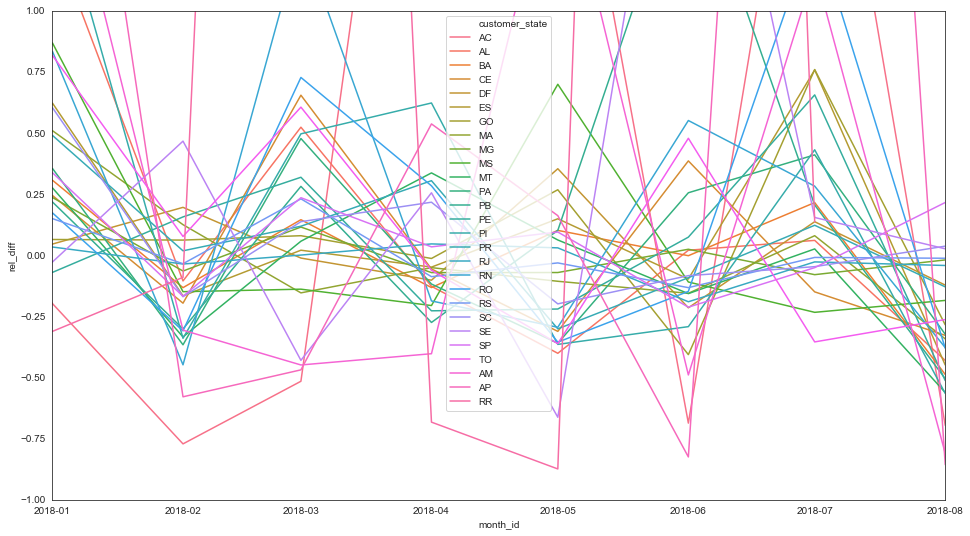

In [84]:
fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(data=monthly_rev_growth,
             x="month_id",
             y="rel_diff",
             hue="customer_state",
             ax=ax);
ax.set_xlim("2018-01-01", "2018-08-01");
ax.set_ylim(-1,1);

In [85]:
monthly_rev_growth.tail(20)

,month_id,month_in_year,year,customer_state,grouped_customer_state,revenue,revenue_y,rel_diff
513,2018-08-01,8,2018,DF,Other,19941.629945,22719.930079,-0.122285
514,2018-08-01,8,2018,ES,Other,16610.039952,30146.350048,-0.449020
515,2018-08-01,8,2018,GO,Other,18063.890013,25253.799875,-0.284706
516,2018-08-01,8,2018,MA,Other,4246.200000,6455.429960,-0.342228
517,2018-08-01,8,2018,MG,MG,95736.419767,97627.710071,-0.019372
518,2018-08-01,8,2018,MS,Other,5551.429983,6810.830020,-0.184911
519,2018-08-01,8,2018,MT,Other,4648.230000,10599.639984,-0.561473
520,2018-08-01,8,2018,PA,Other,8928.779978,13195.939995,-0.323369
521,2018-08-01,8,2018,PB,Other,7751.629988,15657.679998,-0.504931
522,2018-08-01,8,2018,PE,Other,11927.030014,24482.029960,-0.512825
